In [21]:
%matplotlib inline
import fasta_subseq_2 as fa
import seq_plotmethods as sp
#import chipseq_processing as cp
import itertools as it
import tables as tb
import numpy as np
import subprocess as subp
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import gzip
import tarfile
import re
import patser_tools as pat
#import matplotlib_venn as vn 
import os
import shutil
from __future__ import division
from skimage import io as skio
from skimage import transform as skxform

# set up plotting environment for LaTeX compatability
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif') 

In [22]:
class chipExpt():
    def __init__(self,group,name="NoName",chrs=DMEL_CHRS_EU,chr_ext='ext'):
        self.chr_dict = {}
        self.group = group
        self.name = name
        arrays = group._v_children.items()
        if chrs:
            for ch in chrs:
                chr_found = 0
                for (name,node) in arrays:
                    if re.search(chr_ext + "\w*_(chr)?"+ch+"$",name):
                        #print (ch,name,node.name)
                        chr_found = 1
                        self.chr_dict[ch] = node
                        break
                if chr_found == 0:
                    print "no chr found for %s" % (ch,)
        else:
            for n in group._f_walkNodes():
                ch_s = re.search("chr(.+)",n.name)
                self.chr_dict[ch_s.group(1)] = n
                break
                    
    def __getitem__(self,item):
        return self.chr_dict[item]

    def write_wig(self,chr_convert=None,span=10,outfile=None):
        if outfile == None:
            outfile = self.name + ".wig"
        wigout = open(outfile,"w")
        print >> wigout, "track type=wiggle_0 name=%s description=%s visibility=full autoScale=off maxHeightPixels=100:50:20" % (self.name,self.name)
        for (chrom,chr_arr) in self.chr_dict.items():
            print "Writing %s..." % (chrom,),
            name = chrom
            if chr_convert != None:
                name = chr_convert[chrom]
            print >> wigout, "variableStep chrom=%s span=%d" % (name,span)
            for i in np.arange(1,len(chr_arr),step=span):
                print >> wigout, "%d\t%f" % (i,np.sum(chr_arr[i:i+span])/float(span))
            print "done!"
        wigout.close()

## Datasets:

1. Early developmental **genes** from Bradley et. al. (2010)
2. Early developmental **enhancers** from Paris et. al. (2012?)
3. RedFly - wider set, harder to parse?

In [23]:
# Working directory; change if necessary
home = os.environ["HOME"]
current_dir = home + "/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/"
genomes_dir = current_dir + "genomes/"
reads_dir = current_dir + "reads/"
data_out_dir = current_dir + "data/"
figs_dir = current_dir + "figs/"
scripts_dir = current_dir + "scripts/"
mapping_dir = data_out_dir + "mapping/"
peaks_dir = data_out_dir + "peaks/"
h5_dir = data_out_dir + "hf5/"

# Define chromosome names for dmel and dpse
DMEL_CHRS = ['2L','2R','3L','3R','X','YHet','4','2LHet','2RHet','3LHet','3RHet','XHet','U','Uextra']
DMEL_CHRS_EU = ['2L','2R','3L','3R','X']

# Load treatment data

# giant ChIP
gtAm_h5 = tb.open_file(h5_dir+'gtA_dmel.h5', mode='r+')
gtPm_h5 = tb.open_file(h5_dir+'gtP_dmel.h5', mode='r+')
gtCm_h5 = tb.open_file(h5_dir+'gtC_dmel.h5', mode='r+')
gtW1m_h5 = tb.open_file(h5_dir+'gtW1_dmel.h5', mode='r+')
gtW2m_h5 = tb.open_file(h5_dir+'gtW2_dmel.h5', mode='r+')

# Load dmel input data - concatenated reads from all input samples
inAllm_h5 = tb.open_file(h5_dir+'inAll_dmel.h5', mode='r+')

# make chipExpt objects for all above (tag-normed and raw counts)
gtAm_tn = chipExpt(gtAm_h5.root.tag_counts.ext_tags,"Dmel Ant GT ChIP, tag-normalized")
gtPm_tn = chipExpt(gtPm_h5.root.tag_counts.ext_tags,"Dmel Post GT ChIP, tag-normalized")
gtCm_tn = chipExpt(gtCm_h5.root.tag_counts.ext_tags,"Dmel Combo GT ChIP, tag-normalized")
gtW1m_tn = chipExpt(gtW1m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep1 GT ChIP, tag-normalized")
gtW2m_tn = chipExpt(gtW2m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep2 GT ChIP, tag-normalized")

# Load Peak Data
try:
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")
except ValueError:
    pks_h5.close()
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")

# GT peaks    
gtAm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtA_dmel_peaks.xls",expt_name="gtAm_pks")
gtPm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtP_dmel_peaks.xls",expt_name="gtPm_pks")
gtCm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtC_dmel_peaks.xls",expt_name="gtCm_pks")
gtW1m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW1_dmel_peaks.xls",expt_name="gtW1m_pks")
gtW2m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW2_dmel_peaks.xls",expt_name="gtW2m_pks")

gtAm_pks = [x for x in sp.pks_to_dict(gtAm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtPm_pks = [x for x in sp.pks_to_dict(gtPm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtCm_pks = [x for x in sp.pks_to_dict(gtCm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW1m_pks = [x for x in sp.pks_to_dict(gtW1m_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW2m_pks = [x for x in sp.pks_to_dict(gtW2m_pks_tb) if x['chr'] in DMEL_CHRS_EU]

(gtm_un0_pks,gtm_in0_pks,gtm_OL0_pks) = sp.peak_union(0,0,['gtAm','gtPm','gtCm','gtW1m','gtW2m'],True,gtAm_pks,gtPm_pks,gtCm_pks,gtW1m_pks,gtW2m_pks)
gtm_5wy_OLs = [x for x in gtm_in0_pks if len(set(x['sets'])) == 5]
print "GT Dmel Final 5-way overlaps: %d" % (len(gtm_5wy_OLs))

# Get matching peak sets from each GT dataset
(top1000gtW1m_5wy_OL_pi,top1000gtW1m_5wy_OL) = zip(*sp.get_top_n_peaks(1000,gtm_5wy_OLs,gtW1m_tn))
gtAm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtAm_tn)
gtPm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtPm_tn)
gtW1m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW1m_tn)
gtW2m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW2m_tn)
gtCm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtCm_tn)

# Get 5-way union peak sets from each GT experiment
gtAm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtAm_tn)
gtPm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtPm_tn)
gtW1m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW1m_tn)
gtW2m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW2m_tn)
gtCm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtCm_tn)

gff_h5 = h5_dir + "/gff.h5"
gff_dmel = sp.GFFtable(genomes_dir + "/dmel-all-r5.17_genes.gff",gff_h5,DMEL_CHRS_EU,"gene")

b2010_genes = "brk, D, Doc1, Doc2, E(spl), Kr, Phm, SoxN, vnd, bowl, btd, cad, croc, dpp, ems, eve, fkh, ftz, gt, h, hb, hkb, ind, kni, knrl, noc, nub, oc, odd, opa, os, pdm2, pnr, prd, pxb, rho, run, salm, shn, sim, slp1, slp2, sna, sob, sog, ths, tld, tll, tsh, tup, twi, vn, wntD, zen".split(", ")
b2010_locs = [(g,gff_dmel.gene_location(g)) for g in b2010_genes]




Peak window (peak width +/- 0)
Starting Sets:
	gtAm :     3000 peaks
	gtPm :      915 peaks
	gtCm :     1870 peaks
	gtW1m :     1629 peaks
	gtW2m :     1557 peaks
8971 total peaks in starting set
3333 in union, 2022 in intersect
final isct: 2022 before filtering, 2022 after
total overlapping peaks (all sets): 4044
By-Experiment Overlap Counts:
	gtPm :      165
	gtCm :     1054
	gtW2m :      380
	gtW1m :      745
	gtAm :     1700
GT Dmel Final 5-way overlaps: 634


In [ ]:
def load_peak_sets(pk_file):
    pks = []
    for (i,p) in enumerate(open(pk_file)):
        if i > 0:
            pk_in = p[:-1].split("\t")
            pk = (pk_in[5],pk_in[6],pk_in[7],pk_in[8],pk_in[9],pk_in[10],pk_in[11],{'chr':pk_in[0],'start':pk_in[1],'end':pk_in[2],'summit':pk_in[3],'length':pk_in[4]})
            pks.append(pk)
    return pks

gtA_fdr1_pkbind = load_peak_sets(data_out_dir + "/supp_data/gtA_fdr1_pkbind.tsv")
gtP_fdr1_pkbind = load_peak_sets(data_out_dir + "/supp_data/gtP_fdr1_pkbind.tsv")
gtA_fdr1_pk = [x[7] for x in gtA_fdr1_pkbind]
gtP_fdr1_pk = [x[7] for x in gtP_fdr1_pkbind]
notcp_fdr1_pkbind = load_peak_sets(data_out_dir + '/supp_data/gtALL_fdr1_notcp_highpkbind.tsv')
notcp_fdr1_pk = [x[7] for x in notcp_fdr1_pkbind]
print notcp_fdr1_pk

### A/P biased peak overlap w/ region around developmental genes

In [25]:
def get_region_binding(reg,win=0,*expts):
    b_arrays = {}
    for ex in expts:
        b_arrays[ex.name] = ex[reg['chr']][reg['start']-win:reg['end']+win]
    return b_arrays

def biased_binding_proportion(reg,win,expt1,expt2):
    reg_bind = get_region_binding(reg,win,expt1,expt2)
    biased_binding = np.abs(reg_bind[expt1.name] - reg_bind[expt2.name])
    total_binding = reg_bind[gtAm_tn.name] + reg_bind[gtPm_tn.name]
    return np.sum(biased_binding) / np.sum(total_binding)

def biased_binding(reg,win,expt1,expt2):
    reg_bind = get_region_binding(reg,win,expt1,expt2)
    biased_binding = np.abs(reg_bind[expt1.name] - reg_bind[expt2.name])
    return np.sum(biased_binding) / len(biased_binding)

def log_odds_binding(reg,win,expt1,expt2):
    reg_bind = get_region_binding(reg,win,expt1,expt2)
    biased_binding = np.log(np.sum(reg_bind[expt1.name])/np.sum(reg_bind[expt2.name]))
    return biased_binding

def Abias_Pbias_diff(reg,win,expt1,expt2):
    reg_bind = get_region_binding(reg,win,expt1,expt2)
    biased_binding_diff = (reg_bind[expt1.name] - reg_bind[expt2.name])
    biased_binding = max(biased_binding_diff) - min(biased_binding_diff)
    return biased_binding

def df_pk_overlap(df,pk,dfchr='chr',pkchr='chr',dfst='start',pkst='start',dfend='end',pkend='end',pkwin=0):
    pk_start = pk[pkst] - pkwin
    pk_end = pk[pkend] + pkwin
    return df.loc[((df[dfchr] == pk[pkchr]) &
                   ((((df[dfst] >= pk_start) & (df[dfst] <= pk_end)) |
                     ((df[dfend] >= pk_start) & (df[dfend] <= pk_end))) |
                    (((pk_start >= df[dfst]) & (pk_start <= df[dfend])) & 
                     ((pk_end >= df[dfst]) & (pk_end <= df[dfend])))) )]

class chipExpt():
    def __init__(self,group,name="NoName",chrs=DMEL_CHRS_EU,chr_ext='ext'):
        self.chr_dict = {}
        self.group = group
        self.name = name
        arrays = group._v_children.items()
        if chrs:
            for ch in chrs:
                chr_found = 0
                for (name,node) in arrays:
                    if re.search(chr_ext + "\w*_(chr)?"+ch+"$",name):
                        #print (ch,name,node.name)
                        chr_found = 1
                        self.chr_dict[ch] = node
                        break
                if chr_found == 0:
                    print "no chr found for %s" % (ch,)
        else:
            for n in group._f_walkNodes():
                ch_s = re.search("chr(.+)",n.name)
                self.chr_dict[ch_s.group(1)] = n
                break
                    
    def __getitem__(self,item):
        return self.chr_dict[item]

    def write_wig(self,chr_convert=None,span=10,outfile=None):
        if outfile == None:
            outfile = self.name + ".wig"
        wigout = open(outfile,"w")
        print >> wigout, "track type=wiggle_0 name=%s description=%s visibility=full autoScale=off maxHeightPixels=100:50:20" % (self.name,self.name)
        for (chrom,chr_arr) in self.chr_dict.items():
            print "Writing %s..." % (chrom,),
            name = chrom
            if chr_convert != None:
                name = chr_convert[chrom]
            print >> wigout, "variableStep chrom=%s span=%d" % (name,span)
            for i in np.arange(1,len(chr_arr),step=span):
                print >> wigout, "%d\t%f" % (i,np.sum(chr_arr[i:i+span])/float(span))
            print "done!"
        wigout.close()

{'boxes': [<matplotlib.lines.Line2D at 0x119a35110>,
 'caps': [<matplotlib.lines.Line2D at 0x11ea4b050>,
 'fliers': [<matplotlib.lines.Line2D at 0x11ea57350>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11ea4bcd0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x119a35310>,
  <matplotlib.lines.Line2D at 0x11fcc3610>]}

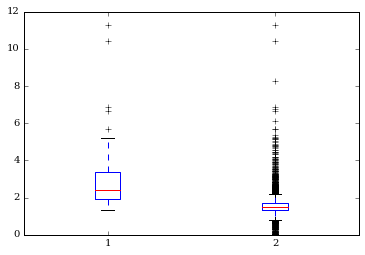

In [60]:
# using log-odds (ratio) scoring
b2010_reg_binding_APnormdiff = [(g,r,biased_binding(r,5000,gtAm_tn,gtPm_tn)) for (g,r) in b2010_locs]
all_genes_reg_binding_APnormdiff = [(g,biased_binding(g,5000,gtAm_tn,gtPm_tn)) for g in gff_dmel.get_all_entry_type('gene')]
b2010_genes_5k_APdiff = open(data_out_dir + "supp_data/b2010_5k_APdiff.tsv","w+")
all_genes_5k_APdiff = open(data_out_dir + "supp_data/all_genes_5k_APdiff.tsv","w+")

print >> b2010_genes_5k_APdiff, "gene\tFBid\tchr\tstart\tend\tstrand\tAP_norm_diff"
for g in b2010_reg_binding_APnormdiff:
    print >> b2010_genes_5k_APdiff, "%s\t%s\t%s\t%d\t%d\t%s\t%f" % (g[0],g[1]['FBid'],g[1]['chr'],g[1]['start'],g[1]['end'],g[1]['strand'],g[2])
b2010_genes_5k_APdiff.close()

print >> all_genes_5k_APdiff, "gene\tFBid\tchr\tstart\tend\tstrand\tAP_norm_diff"
for g in all_genes_reg_binding_APnormdiff:
    print >> all_genes_5k_APdiff, "%s\t%s\t%s\t%d\t%d\t%s\t%f" % (g[0]['name'],g[0]['FBid'],g[0]['chr'],g[0]['start'],g[0]['end'],g[0]['strand'],g[1])
all_genes_5k_APdiff.close()

#print b2010_reg_binding_APnormdiff
#print all_genes_reg_binding_APnormdiff
#plt.gcf().set_figheight(10)
#plt.gcf().set_figwidth(10)

#all_gene_vals_APlogodds = np.array([x[1] for x in all_genes_reg_binding_APlogodds if np.isfinite(x[1])])
#all_gene_vals_APlogodds = np.nan_to_num(all_gene_vals_wnan_APlogodds)
#b2010_bind_ratios_APlogodds = np.array(zip(*b2010_reg_binding_APlogodds)[1])
#print [x[1] for x in all_genes_reg_binding_APnormdiff]
#print np.sum(sorted([x[1] for x in all_genes_reg_binding_APnormdiff if np.isfinite(np.float(x))]))
#fx = []
#for z in [x[1] for x in all_genes_reg_binding_APnormdiff]:
#    try:
#        fx.append(np.float(z))
#    except:
#        print "ERR:" + str(z)
b2010_vals = np.array([x[2] for x in b2010_reg_binding_APnormdiff])
all_vals = np.array([x[1] for x in all_genes_reg_binding_APnormdiff if not np.isnan(x[1])])
plt.boxplot([b2010_vals,all_vals])
#print fx
#plt.vlines(b2010_bind_ratios_APlogodds,0,1600,colors='r')

In [185]:
gtA_pk_df = pd.DataFrame(columns=['chr','start','end'],index=np.arange(len(gtA_fdr1_pk)))
gtA_pk_df['chr'] = [x['chr'] for x in gtA_fdr1_pk]
gtA_pk_df['start'] = [int(x['start']) for x in gtA_fdr1_pk]
gtA_pk_df['end'] = [int(x['end']) for x in gtA_fdr1_pk]
gtA_pk_df['summit'] = [int(x['summit']) for x in gtA_fdr1_pk]

gtP_pk_df = pd.DataFrame(columns=['chr','start','end'],index=np.arange(len(gtP_fdr1_pk)))
gtP_pk_df['chr'] = [x['chr'] for x in gtP_fdr1_pk]
gtP_pk_df['start'] = [int(x['start']) for x in gtP_fdr1_pk]
gtP_pk_df['end'] = [int(x['end']) for x in gtP_fdr1_pk]
gtP_pk_df['summit'] = [int(x['summit']) for x in gtP_fdr1_pk]

gtND_pk_df = pd.DataFrame(columns=['chr','start','end'],index=np.arange(len(notcp_fdr1_pk)))
gtND_pk_df['chr'] = [x['chr'] for x in notcp_fdr1_pk]
gtND_pk_df['start'] = [int(x['start']) for x in notcp_fdr1_pk]
gtND_pk_df['end'] = [int(x['end']) for x in notcp_fdr1_pk]
gtND_pk_df['summit'] = [int(x['summit']) for x in notcp_fdr1_pk]

gtAll_pk_df = pd.concat([gtA_pk_df,gtP_pk_df,gtND_pk_df],ignore_index=True)
gtBias_pk_df = pd.concat([gtA_pk_df,gtP_pk_df],ignore_index=True)

In [188]:
gtAll_pk_df.shape
gtBias_pk_df.shape

(599, 4)

In [190]:
b2010_locs_Ser = [(k,pd.Series(v)) for (k,v) in b2010_locs]
b2010_locs_df = pd.DataFrame.from_items(b2010_locs_Ser,orient='index',columns=b2010_locs_Ser[0][1].index)
b2010_gtBias_10kwin = []
for x in b2010_locs_df.iterrows():
    hits = df_pk_overlap(gtBias_pk_df,x[1],pkwin=5000)
    hits['target_gene'] = x[0]
    gene_start = None
    if x[1]['strand'] == "+":
        gene_start = x[1]['start']
    else:
        gene_start = x[1]['end']
    hits['summit_target_tss_dist'] = hits['summit'] - gene_start
    b2010_gtBias_10kwin.append(hits)
#print [(n,ol.shape[0]) for (n,ol) in b2010_gtALL_10kwin.items()]
b2010_gtBias_10kwin = pd.concat(b2010_gtBias_10kwin,ignore_index=True)
b2010_gtBias_10kwin.to_csv(data_out_dir + "supp_data/Bias_peaks_5kwin_devgenes.tsv",sep="\t")

b2010_gt_un0_10kwin = []
for x in b2010_locs_df.iterrows():
    hits = df_pk_overlap(gtAll_pk_df,x[1],pkwin=5000)
    hits['target_gene'] = x[0]
    gene_start = None
    if x[1]['strand'] == "+":
        gene_start = x[1]['start']
    else:
        gene_start = x[1]['end']
    hits['summit_target_tss_dist'] = hits['summit'] - gene_start
    b2010_gt_un0_10kwin.append(hits)
b2010_gt_un0_10kwin = pd.concat(b2010_gt_un0_10kwin,ignore_index=True)
b2010_gt_un0_10kwin.to_csv(data_out_dir + "supp_data/all_un0_peaks_5kwin_devgenes.tsv",sep="\t")
print b2010_gt_un0_10kwin.shape
print b2010_gtBias_10kwin.shape
#b2010_gtALL_pk_cnt.name = 'gtBias'
#print b2010_gtALL_pk_cnt

/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

(97, 6)
(63, 6)


In [74]:
# Import developmental enhancer list from Mathilde's paper
mp2013_enhancers = pd.read_csv("~/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/enhancers/Paris_etal_2013.tsv",sep="\t")
mp2013_enhancers["Chromosome"] = mp2013_enhancers["Chromosome"].apply((lambda x: re.sub("chr","",x)))
mp2013_enhancers.columns = pd.Index([u'NAME', u'Source', u'chr', u'start', u'end'], dtype=object)

In [192]:
mp2013_enhancers_gtBias_overlap = []
for x in mp2013_enhancers.iterrows():
    hits = df_pk_overlap(gtBias_pk_df,x[1],pkwin=0)
    hits['enh_name'] = x[1]['NAME']
    hits['enh_source'] = x[1]['Source']
    hits['enh_start'] = x[1]['start']
    hits['enh_end'] = x[1]['end']
    mp2013_enhancers_gtBias_overlap.append(hits)
mp2013_enhancers_gtBias_overlap = pd.concat(mp2013_enhancers_gtBias_overlap,ignore_index=True)
print mp2013_enhancers_gtBias_overlap.shape

mp2013_enhancers_gt_un0_overlap = []
for x in mp2013_enhancers.iterrows():
    hits = df_pk_overlap(gtAll_pk_df,x[1],pkwin=0)
    hits['enh_name'] = x[1]['NAME']
    hits['enh_source'] = x[1]['Source']
    hits['enh_start'] = x[1]['start']
    hits['enh_end'] = x[1]['end']
    mp2013_enhancers_gt_un0_overlap.append(hits)
mp2013_enhancers_gt_un0_overlap = pd.concat(mp2013_enhancers_gt_un0_overlap,ignore_index=True)
#mp2013_enhancers_gt_un0_overlap.to_csv(data_out_dir + "supp_data/all_un0_peaks_5kwin_devgenes.tsv",sep="\t")
print mp2013_enhancers_gt_un0_overlap.shape



/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

(112, 8)


/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

(153, 8)


In [157]:
print len(mp2013_enhancers_gtBias_overlap)

112


In [194]:
mp2013_enhancers_gtBias_overlap_flt = []

def calculate_pk_enh_overlap(pk_overlap_df):
    overlap = []
    for i in range(0,len(pk_overlap_df)):
        r = pk_overlap_df.loc[i]
        pk_length = float(r['end'] - r['start'])
        frac_overlap = 0
        if (r['enh_end'] < r['end']) and r['enh_start'] > r['start']:
            frac_overlap = (r['enh_end'] - r['enh_start']) / pk_length
        elif (r['end'] < r ['enh_end']) and ['start'] > ['enh_start']:
            frac_overlap =  (r['end'] - r['start']) / pk_length
        elif (r['enh_end'] < r['end']):
            frac_overlap = (r['enh_end'] - r['start']) / pk_length
        elif (r['enh_start'] > r['start']):
            frac_overlap = (r['end'] - r['enh_start']) / pk_length
        overlap.append(frac_overlap)
    pk_overlap_df["Overlap"] = overlap

calculate_pk_enh_overlap(mp2013_enhancers_gtBias_overlap)
calculate_pk_enh_overlap(mp2013_enhancers_gt_un0_overlap)

mp2013_enhancers_gtBias_overlap_flt = mp2013_enhancers_gtBias_overlap[mp2013_enhancers_gtBias_overlap["Overlap"] > 0.6]
mp2013_enhancers_gtBias_overlap_flt.to_csv(data_out_dir + "supp_data/Bias_pks_mp2013_enhancers_overlap_flt.tsv",sep="\t")

mp2013_enhancers_gt_un0_overlap_flt = mp2013_enhancers_gt_un0_overlap[mp2013_enhancers_gt_un0_overlap["Overlap"] > 0.6]
mp2013_enhancers_gt_un0_overlap_flt.to_csv(data_out_dir + "supp_data/All_pks_mp2013_enhancers_overlap_flt.tsv",sep="\t")


In [170]:
w1w2_mean_5un = (gtW1m_5un_tn + gtW2m_5un_tn) / 2
#AP_log2ratio_5un = np.log2(gtAm_5un_tn / gtPm_5un_tn) - np.mean([x for x in np.log2(gtAm_5un_tn / gtPm_5un_tn) if np.isfinite(x)])
#w1w2_log2ratio_5un = np.log2(gtW1m_5un_tn / gtW2m_5un_tn)  - np.mean([x for x in np.log2(gtW1m_5un_tn / gtW2m_5un_tn) if np.isfinite(x)])
AP_diff_5un = (gtAm_5un_tn - gtPm_5un_tn) - np.mean((gtAm_5un_tn - gtPm_5un_tn))
w1w2_diff_5un = gtW1m_5un_tn - gtW2m_5un_tn - np.mean((gtW1m_5un_tn - gtW2m_5un_tn))
w1w2_mean_5un_pkdata = sorted(zip(w1w2_mean_5un,w1w2_diff_5un,AP_diff_5un,gtm_un0_pks),cmp=(lambda x,y: cmp(x[0],y[0])))
w1w2_mean_5un_srt = w1w2_mean_5un_pkdata[::-1]
print len(zip(*w1w2_mean_5un_srt)[1])
#print w1w2_mean_5un_srt

bias2010_dev_srt_idx = []
bias2010_dev_pkvals = []
for (i,p) in enumerate(w1w2_mean_5un_srt):
    for r in b2010_gtBias_10kwin.iterrows():
        if ((p[3]['chr'] == r[1]['chr']) and (p[3]['start'] == r[1]['start'])) and (p[3]['end'] == r[1]['end']):
            bias2010_dev_srt_idx.append(i)
            bias2010_dev_pkvals.append(p)
print bias2010_dev_srt_idx

mp2013_enhancers_gtBias_overlap_flt_srt_idx = []
mp2013_enhancers_gtBias_overlap_flt_pkvals = []
for (i,p) in enumerate(w1w2_mean_5un_srt):
    for r in mp2013_enhancers_gtBias_overlap.iterrows():
        if ((p[3]['chr'] == r[1]['chr']) and (p[3]['start'] == r[1]['start'])) and (p[3]['end'] == r[1]['end']):
            mp2013_enhancers_gtBias_overlap_flt_srt_idx.append(i)
            mp2013_enhancers_gtBias_overlap_flt_pkvals.append(p)
print mp2013_enhancers_gtBias_overlap_flt_srt_idx


3333
[5, 13, 14, 17, 18, 21, 24, 52, 74, 83, 84, 93, 109, 140, 141, 154, 167, 187, 244, 245, 270, 272, 275, 296, 322, 334, 352, 380, 395, 405, 418, 465, 480, 495, 547, 550, 587, 632, 705, 747, 753, 784, 794, 864, 887, 962, 1047, 1074, 1283, 1347, 1367, 1422, 1459, 1551, 1602, 1665, 1700, 1748, 1780, 1786, 2138, 2511, 2570]
[8, 8, 13, 13, 18, 18, 18, 18, 18, 18, 21, 21, 21, 21, 42, 52, 52, 52, 52, 52, 52, 62, 68, 79, 84, 102, 109, 145, 145, 150, 187, 187, 187, 187, 243, 244, 244, 245, 273, 273, 273, 279, 283, 283, 283, 283, 283, 334, 352, 405, 405, 454, 454, 454, 454, 519, 594, 594, 599, 605, 711, 730, 794, 794, 794, 794, 794, 794, 794, 794, 794, 887, 962, 1007, 1047, 1047, 1047, 1047, 1074, 1074, 1074, 1074, 1107, 1107, 1107, 1107, 1107, 1107, 1107, 1193, 1313, 1363, 1367, 1367, 1422, 1459, 1472, 1589, 1700, 1780, 1908, 2006, 2032, 2179, 2179, 2179, 2179, 2257, 2257, 2334, 2511, 2620]


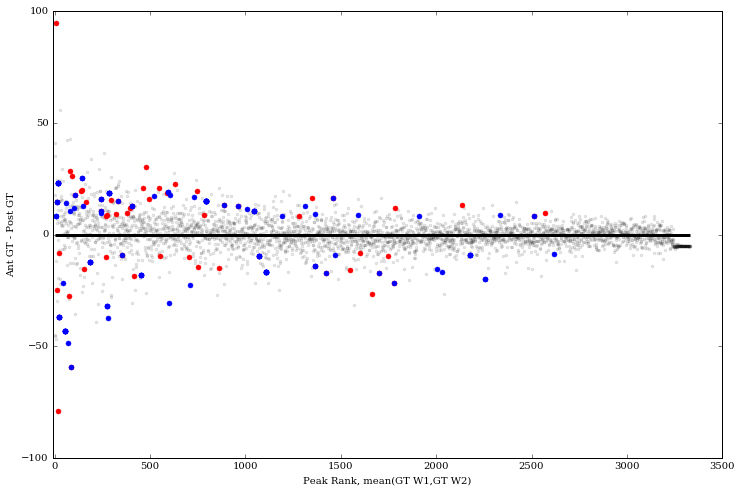

In [178]:

plt.gcf().set_figwidth(12)
plt.gcf().set_figheight(8)
#plt.subplot(211)
plt.ylim(-100,100)
plt.xlim(-10,3500)
plt.hlines(0.0,0,len(w1w2_mean_5un_srt),linestyle="-",linewidth=3)
#plt.hlines([gt_5unfdr1_subtr_cut,-gt_5unfdr1_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle="-",linewidth=1,color='red',label='1% FDR Cutoff')
#plt.hlines([gt_5unfdr5_subtr_cut,-gt_5unfdr5_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle=":",linewidth=1,color='red',label='5% FDR Cutoff')
plt.plot(np.arange(len(w1w2_mean_5un_srt)),zip(*w1w2_mean_5un_srt)[2],'k.',alpha=0.1)
plt.plot(bias2010_dev_srt_idx,zip(*bias2010_dev_pkvals)[2],'r.',markersize=10)
plt.plot(mp2013_enhancers_gtBias_overlap_flt_srt_idx,zip(*mp2013_enhancers_gtBias_overlap_flt_pkvals)[2],'b.',markersize=10)
#biasPks = [x[1].to_dict() for x in b2010_gtALL_10kwin.iterrows()]
plt.xlabel("Peak Rank, mean(GT W1,GT W2)")
plt.ylabel("Ant GT - Post GT")
plt.legend()
#plt.subplot(212)
#plt.ylim(-100,100)
#plt.plot(np.arange(len(w1w2_mean_5un_srt)),zip(*w1w2_mean_5un_srt)[1],'k.',alpha=0.5)
#plt.hlines(0.0,0,len(w1w2_mean_5un_srt),linestyle="-",linewidth=3)
#plt.hlines([gt_5unfdr1_subtr_cut,-gt_5unfdr1_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle="-",linewidth=1,color='red',label='1% FDR Cutoff')
#plt.hlines([gt_5unfdr5_subtr_cut,-gt_5unfdr5_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle=":",linewidth=1,color='red',label='5% FDR Cutoff')


In [181]:
all_5un_pks_out = open(data_out_dir + "supp_data/all_5un_pks_binding_bias.tsv","w+")
print >> all_5un_pks_out, "chr\tstart\tend\tlength\tsummit\tW1_W2_MEAN\tW1_W2_DIFF\tA_P_DIFF"
for x in w1w2_mean_5un_srt:
    print >> all_5un_pks_out, "%s\t%d\t%d\t%d\t%d\t%4f\t%4f\t%4f" % (x[3]['chr'],x[3]['start'],x[3]['end'],x[3]['length'],x[3]['summit'],x[0],x[1],x[2])
all_5un_pks_out.close()